In [ ]:
!pip install pycaret --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 756.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 136.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 128.6 MB/s eta 0:00:00

In [ ]:

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d patrickzel/flight-delay-and-cancellation-dataset-2019-2023

!unzip flight-delay-and-cancellation-dataset-2019-2023.zip



Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   


In [ ]:
import pandas as pd

df = pd.read_csv("/content/flights_sample_3m.csv")


In [ ]:
# Subset 1 million rows
df = df.sample(n=300000, random_state=42).reset_index(drop=True)

# Only drop rows where critical columns are missing
important_cols = ['FL_DATE', 'AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DISTANCE']
df = df.dropna(subset=important_cols)

print(f"Dataset shape after cleaning important columns only: {df.shape}")


Dataset shape after cleaning important columns only: (300000, 32)


In [ ]:
# Create IS_DELAYED before dropping anything
df['IS_DELAYED'] = (df['DEP_DELAY'] > 15).astype(int)

print("Target Variable Value Counts:")
print(df['IS_DELAYED'].value_counts())


Target Variable Value Counts:
IS_DELAYED
0    248538
1     51462
Name: count, dtype: int64


In [ ]:
# Define leakage columns
leakage_cols = [
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
    'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

# Drop leakage columns AFTER target created
df.drop(columns=[col for col in leakage_cols if col in df.columns], inplace=True)

print(f"Columns after dropping leakage: {df.columns.tolist()}")


Columns after dropping leakage: ['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'IS_DELAYED']


In [ ]:
from pycaret.classification import *

# Setup AutoML
clf_setup = setup(
    data=df,
    target='IS_DELAYED',
    session_id=42,
    ignore_features=['FL_DATE'],
    fold_strategy='stratifiedkfold',
    fold=3,                      # Cut training time by 40%
    use_gpu=True,
    fix_imbalance=True,         # SMOTE to improve recall
    verbose=False
)



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

In [ ]:
base_models = compare_models(
    include=['lr', 'xgboost', 'lightgbm', 'rf', 'et'],
    n_select=3,    # Select top 3 models for stacking
    sort='F1'
)

print(base_models)

# Now stack them
stacked_model = stack_models(base_models)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5850,0.6266,0.6120,0.2315,0.3360,0.1159,0.1450,3.7233
et,Extra Trees Classifier,0.7620,0.5835,0.2051,0.2570,0.2282,0.0895,0.0903,13.6500
xgboost,Extreme Gradient Boosting,0.8008,0.6278,0.1205,0.2997,0.1718,0.0815,0.0925,4.2500


Processing:   0%|          | 0/27 [00:00<?, ?it/s]

[LogisticRegression(), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False), XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_thre

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.6098,0.1851,0.2696,0.2195,0.0928,0.0950
1,0.7746,0.6109,0.1907,0.2742,0.2250,0.0980,0.1002
2,0.7747,0.6113,0.1932,0.2762,0.2274,0.1003,0.1025
Mean,0.7745,0.6107,0.1897,0.2733,0.2239,0.0970,0.0992
Std,0.0002,0.0006,0.0034,0.0028,0.0033,0.0032,0.0031


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Finalize model
final_model = finalize_model(stacked_model)

# Predict on the same data (or you can use new unseen data)
predictions = predict_model(final_model, data=df)

# Check predictions
predictions[['prediction_label', 'prediction_score']].head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9668,0.9948,0.8497,0.9518,0.8979,0.8781,0.8802


,prediction_label,prediction_score
0,1,0.5811
1,0,0.9416
2,0,0.9222
3,0,0.9151
4,0,0.8535


In [ ]:
# Merge predictions back to dataset
df['PREDICTED_DELAY'] = predictions['prediction_label']
df['DELAY_PROBABILITY'] = (predictions['prediction_score'] * 100).round(2)

# Save or display
df[['FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'PREDICTED_DELAY', 'DELAY_PROBABILITY']].head()

# Optionally save to CSV
df.to_csv('flight_delay_predictions_automl.csv', index=False)

print("Final dataset with delay probabilities saved")


Final dataset with delay probabilities saved


In [ ]:
# Save the final stacked model
save_model(final_model, 'stacked_flight_delay_model')

print("Model saved successfully as 'stacked_flight_delay_model.pkl'")


Transformation Pipeline and Model Successfully Saved
Model saved successfully as 'stacked_flight_delay_model.pkl'


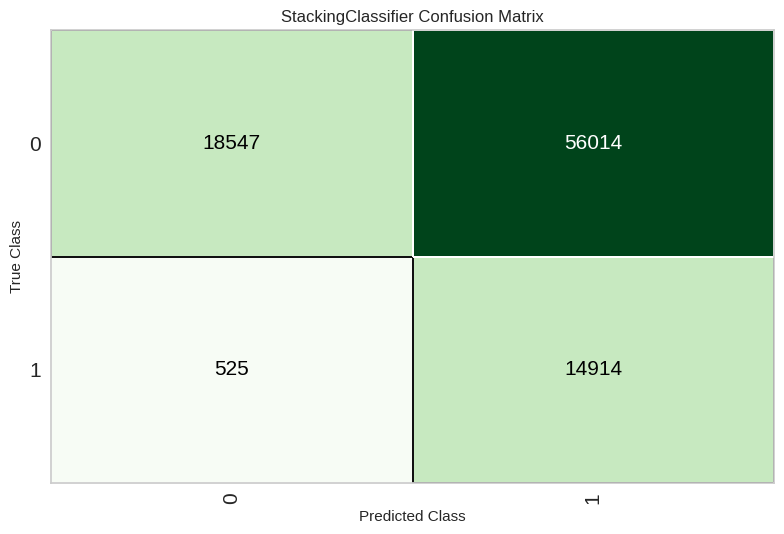

In [ ]:
# Plot confusion matrix
plot_model(final_model, plot='confusion_matrix')


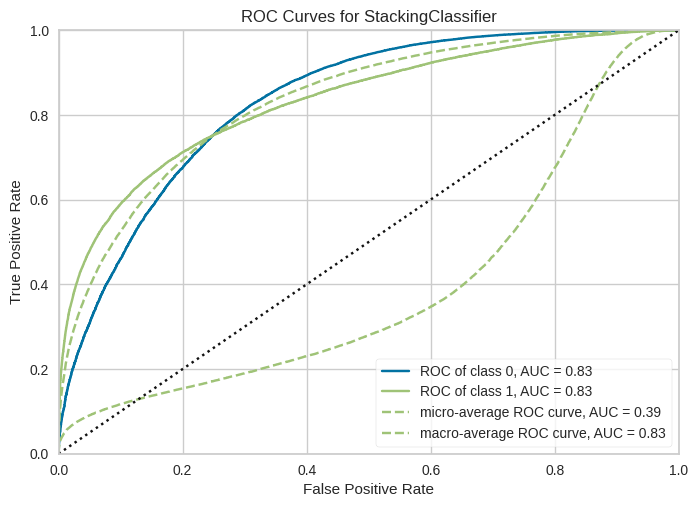

In [ ]:
# Plot ROC-AUC Curve
plot_model(final_model, plot='auc')
